# Generalized Tikhonov Regularization & Error Analysis
### Mathematics for Imaging and Signal Processing — A.A. 2025/2026

---

**The problem we are solving.** We want to recover a sharp image $f$ from a blurred and noisy observation

$$g = Af + w,$$

where $A$ is the convolution with a PSF kernel $K$ (the blur), and $w$ is additive Gaussian noise from the recording process. Directly inverting this — dividing by $\hat{K}$ in the Fourier domain — is ill-posed because $\hat{K}(\omega) \to 0$ at high frequencies, which blows up the noise term $\hat{w}/\hat{K}$. So we need **regularization**.

This notebook implements:
1. **Part 1** — The forward problem (simulating blur + noise)
2. **Part 2** — Generalized Tikhonov regularization with $L^2$, $H^1$, $H^2$ penalties
3. **Part 3** — Spectral windowing as a hard cutoff alternative
4. **Part 4** — Bias-variance trade-off analysis

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import j1  # Bessel function J_1, needed for out-of-focus blur

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 11
np.random.seed(42)  # fixed seed so noise realizations are reproducible

In [3]:
def compute_psnr(original, reconstructed):
    """Computes peak signal-to-noise ratio in dB.
    Uses the max pixel value of the original as the 'peak'.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse < 1e-15:
        return float('inf')
    peak_val = np.max(original)
    return 10 * np.log10(peak_val ** 2 / mse)


def show_images(images, titles, suptitle=None, figsize=(16, 4), cbar=True):
    """Quick helper to display a row of grayscale images side by side."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        if cbar:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def show_zoom(images, titles, region, suptitle=None, figsize=(16, 4)):
    """Show each image with a red bounding box on the zoom region,
    then the zoomed crop below it — makes it easy to compare edges."""
    r0, r1, c0, c1 = region
    n = len(images)
    fig, axes = plt.subplots(2, n, figsize=(figsize[0], figsize[1] * 2.2))
    if n == 1:
        axes = axes.reshape(2, 1)
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(title, fontsize=10)
        axes[0, i].axis('off')
        rect = Rectangle((c0, r0), c1 - c0, r1 - r0,
                          linewidth=2, edgecolor='red', facecolor='none')
        axes[0, i].add_patch(rect)
        axes[1, i].imshow(img[r0:r1, c0:c1], cmap='gray')
        axes[1, i].set_title('Zoomed Detail', fontsize=9)
        axes[1, i].axis('off')
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## Part 1 — The Forward Problem (Simulation)

The idea is straightforward: we start from a known sharp image $f^{(0)}$, apply a blur model in the Fourier domain (convolution becomes pointwise multiplication there), and then add noise. This gives us a simulated observation $g$ that we will try to reconstruct in Parts 2–4.

Steps:
1. Choose a test image $f^{(0)}$ of size $256 \times 256$.
2. Build the transfer functions $\hat{K}(\omega)$ for three blur types.
3. Add Gaussian noise at two SNR levels (40 dB and 20 dB).

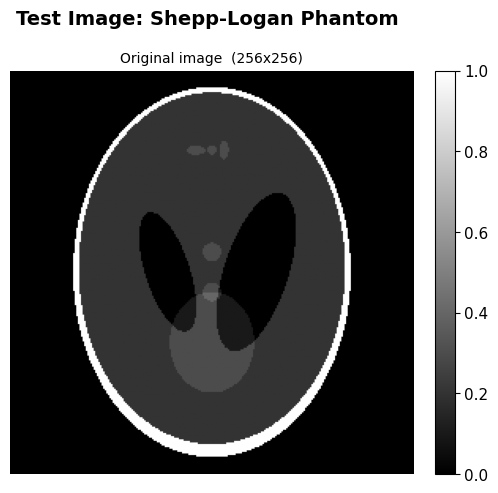

In [4]:
def shepp_logan_phantom(N=256):
    """Was chosen since it has sharp edges of ellipses with different angles,
    hence it will show the effect of different blur types.
    """
    img = np.zeros((N, N), dtype=np.float64)
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)

    # each ellipse: (intensity, semi-axis a, semi-axis b, centre x0, y0, rotation deg)
    ellipses = [
        ( 1.0,   0.6900, 0.9200,  0.0,     0.0,     0),
        (-0.8,   0.6624, 0.8740,  0.0,    -0.0184,  0),
        (-0.2,   0.1100, 0.3100, -0.22,    0.0,    -18),
        (-0.2,   0.1600, 0.4100,  0.22,    0.0,     18),
        ( 0.1,   0.2100, 0.2500,  0.0,     0.35,    0),
        ( 0.1,   0.0460, 0.0460,  0.0,     0.1,     0),
        ( 0.1,   0.0460, 0.0460,  0.0,    -0.1,     0),
        ( 0.1,   0.0460, 0.0230, -0.08,   -0.605,   0),
        ( 0.1,   0.0230, 0.0230,  0.0,    -0.606,   0),
        ( 0.1,   0.0230, 0.0460,  0.06,   -0.605,   0),
    ]

    for rho, a, b, x0, y0, theta_deg in ellipses:
        theta = np.radians(theta_deg)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        Xr =  cos_t * (X - x0) + sin_t * (Y - y0)
        Yr = -sin_t * (X - x0) + cos_t * (Y - y0)
        mask = (Xr / a) ** 2 + (Yr / b) ** 2 <= 1
        img[mask] += rho

    return img


N = 256
f_true = shepp_logan_phantom(N)

show_images([f_true], [f'Original image  ({N}x{N})'],
            suptitle='Test Image: Shepp-Logan Phantom', figsize=(6, 5))

### Frequency Grid Setup (Algorithm 1)

`numpy.fft` puts the zero frequency at index $(0,0)$, but our formulas (Gaussian, Bessel, sinc) assume zero frequency is at the **centre** of the grid. So I build a centred grid first, then call `ifftshift` to rearrange it into the layout that `fft2`/`ifft2` expect. This is what Algorithm 1 in the assignment tells us to do.

In [5]:
# Algorithm 1: set up the discrete frequency mesh
M = N  # square image, so N = M = 256
x_range = np.arange(-N // 2, N // 2)   # [-128, -127, ..., 126, 127]
y_range = np.arange(-M // 2, M // 2)

# 2D meshgrid — centred grid where omega=(0,0) is in the middle
omega_X, omega_Y = np.meshgrid(x_range, y_range)
omega_mag = np.sqrt(omega_X**2 + omega_Y**2)  # radial frequency |omega|

In [36]:
# ============================================================
# Blur Model 1: Gaussian
# ============================================================
# Simplest model — just a Gaussian that smoothly kills high frequencies.

sigma_blur = 3.0
K_hat_gauss_c = np.exp(-omega_mag**2 / (2 * sigma_blur**2))
K_hat_gauss   = ifftshift(K_hat_gauss_c)

# ============================================================
# Blur Model 2: Linear Motion Blur (horizontal, length L pixels)
# ============================================================

L_motion = 15
motion_arg = omega_X * L_motion / 2
K_hat_motion_c = (
    np.exp(-1j * (L_motion / 2) * omega_X)  # phase factor
    * np.sinc(motion_arg / np.pi)             # sinc magnitude
)
K_hat_motion = ifftshift(K_hat_motion_c)

# ============================================================
# Blur Model 3: Out-of-Focus (circular aperture, radius R)
# ============================================================
# Fourier transform of a uniform disk. Unlike Gaussian, it oscillates
# and has actual zeros — at those frequencies we lose info completely.

R_defocus = 8.0
defocus_arg = omega_mag * R_defocus
with np.errstate(divide='ignore', invalid='ignore'):
    K_hat_oof_c = np.where(
        defocus_arg > 1e-10,
        2 * j1(defocus_arg) / defocus_arg,
        1.0  # limit value at |omega| = 0
    )
K_hat_oof = ifftshift(K_hat_oof_c)

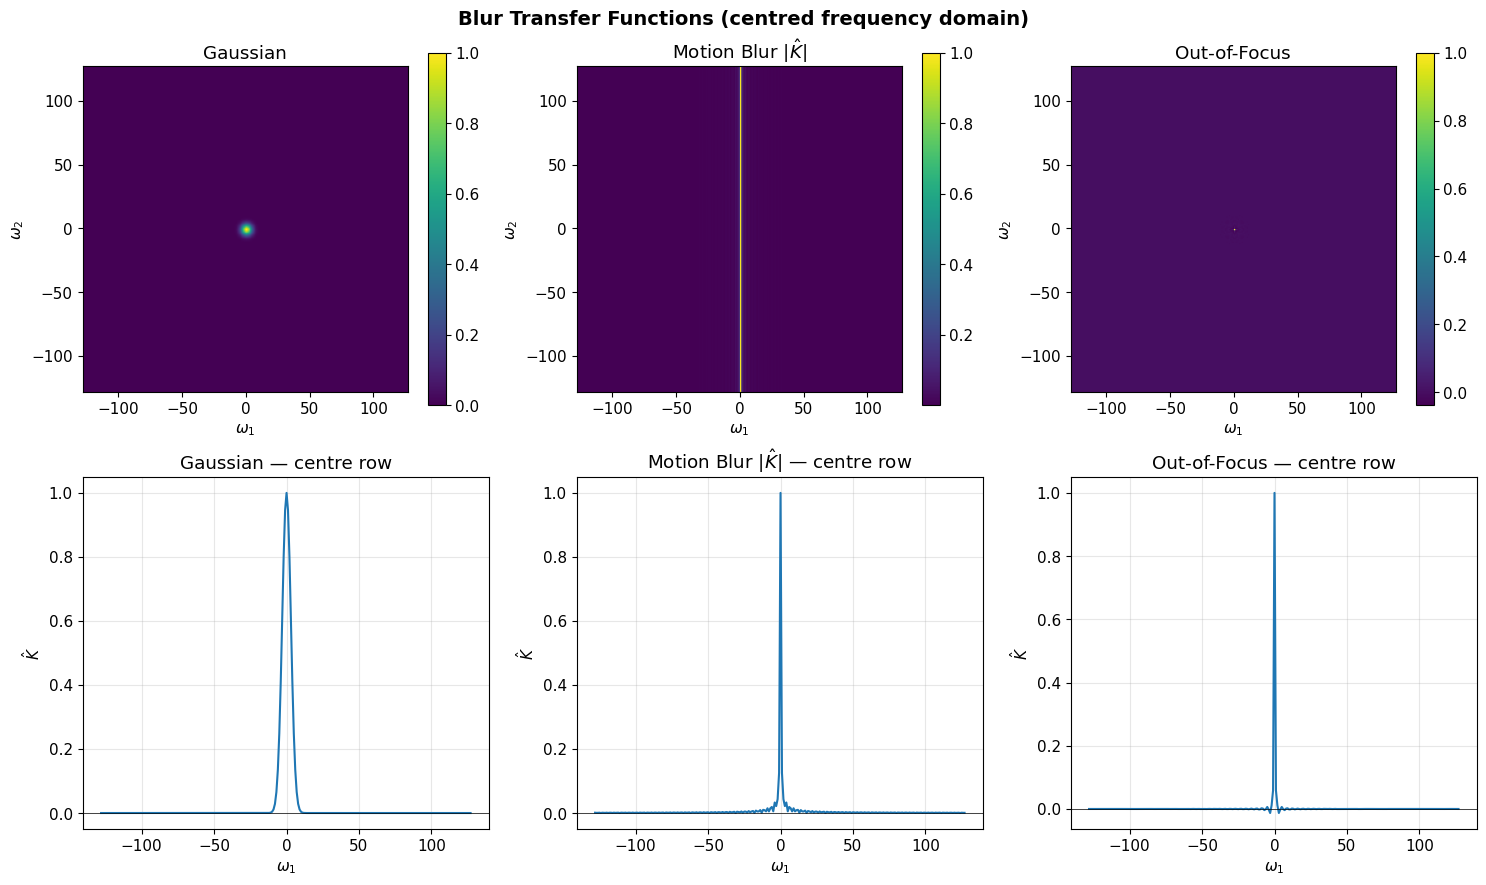

In [7]:
# Let's look at all three transfer functions to build some intuition
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
kernels_c = [K_hat_gauss_c, np.abs(K_hat_motion_c), K_hat_oof_c]
names_blur = ['Gaussian', 'Motion Blur $|\\hat{K}|$', 'Out-of-Focus']
ext = [-N//2, N//2-1, -M//2, M//2-1]

for i, (Kc, name) in enumerate(zip(kernels_c, names_blur)):
    im = axes[0, i].imshow(np.real(Kc), cmap='viridis', extent=ext)
    axes[0, i].set_title(f'{name}')
    axes[0, i].set_xlabel('$\\omega_1$'); axes[0, i].set_ylabel('$\\omega_2$')
    fig.colorbar(im, ax=axes[0, i])

    # 1D slice through the centre row to see the profile
    axes[1, i].plot(x_range, np.real(Kc[N//2, :]))
    axes[1, i].set_xlabel('$\\omega_1$')
    axes[1, i].set_ylabel('$\\hat{K}$')
    axes[1, i].set_title(f'{names_blur[i]} — centre row')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].axhline(0, color='k', linewidth=0.5)

fig.suptitle('Blur Transfer Functions (centred frequency domain)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Forward Problem — Blur + Noise (Algorithm 2)

By the convolution theorem, blurring in space = multiplication in frequency:

$$\hat{g}_{\text{clean}}(\omega) = \hat{K}(\omega) \cdot \hat{f}_{\text{true}}(\omega)$$

Then we add noise in the spatial domain. The noise standard deviation is calibrated so that the SNR (in dB) hits the target:

$$\sigma_{\text{noise}} = 10^{-\mathrm{SNR}_{\mathrm{dB}}/20} \cdot \mathrm{std}(g_{\text{clean}})$$

In [8]:
def forward_problem(f_true, K_hat, snr_db):
    """Algorithm 2: simulate blur + noise.
    Blur in Fourier domain (pointwise multiply), then add Gaussian
    noise in spatial domain with sigma calibrated to the desired SNR.
    """
    f_hat = fft2(f_true)
    g_hat_clean = f_hat * K_hat
    g_clean = np.real(ifft2(g_hat_clean))

    # sigma_noise = std(g_clean) * 10^(-SNR/20)
    sigma_noise = 10 ** (-snr_db / 20) * np.std(g_clean)
    noise = np.random.normal(0, sigma_noise, f_true.shape)

    g = g_clean + noise
    g_hat = fft2(g)
    return g, g_hat, g_clean, sigma_noise, noise


# Generate observations for all 3 blur types at both SNR levels
K_hat_primary   = K_hat_gauss
K_hat_primary_c = K_hat_gauss_c

# Gaussian
g_high, g_hat_high, g_clean, sigma_high, noise_high = forward_problem(f_true, K_hat_primary, 40)
g_low,  g_hat_low,  _,       sigma_low,  noise_low  = forward_problem(f_true, K_hat_primary, 20)

# Motion
g_motion_high, g_hat_motion_high, g_motion_clean, sigma_motion_high, _ = forward_problem(f_true, K_hat_motion, 40)
g_motion_low,  g_hat_motion_low,  _,              sigma_motion_low,  _ = forward_problem(f_true, K_hat_motion, 20)

# Out-of-focus
g_oof_high, g_hat_oof_high, g_oof_clean, sigma_oof_high, _ = forward_problem(f_true, K_hat_oof, 40)
g_oof_low,  g_hat_oof_low,  _,           sigma_oof_low,  _ = forward_problem(f_true, K_hat_oof, 20)

print(f'Gaussian     — sigma_noise (40 dB) = {sigma_high:.6f},  (20 dB) = {sigma_low:.6f}')
print(f'Motion       — sigma_noise (40 dB) = {sigma_motion_high:.6f},  (20 dB) = {sigma_motion_low:.6f}')
print(f'Out-of-Focus — sigma_noise (40 dB) = {sigma_oof_high:.6f},  (20 dB) = {sigma_oof_low:.6f}')

Gaussian     — sigma_noise (40 dB) = 0.000950,  (20 dB) = 0.009498
Motion       — sigma_noise (40 dB) = 0.000466,  (20 dB) = 0.004657
Out-of-Focus — sigma_noise (40 dB) = 0.000047,  (20 dB) = 0.000468


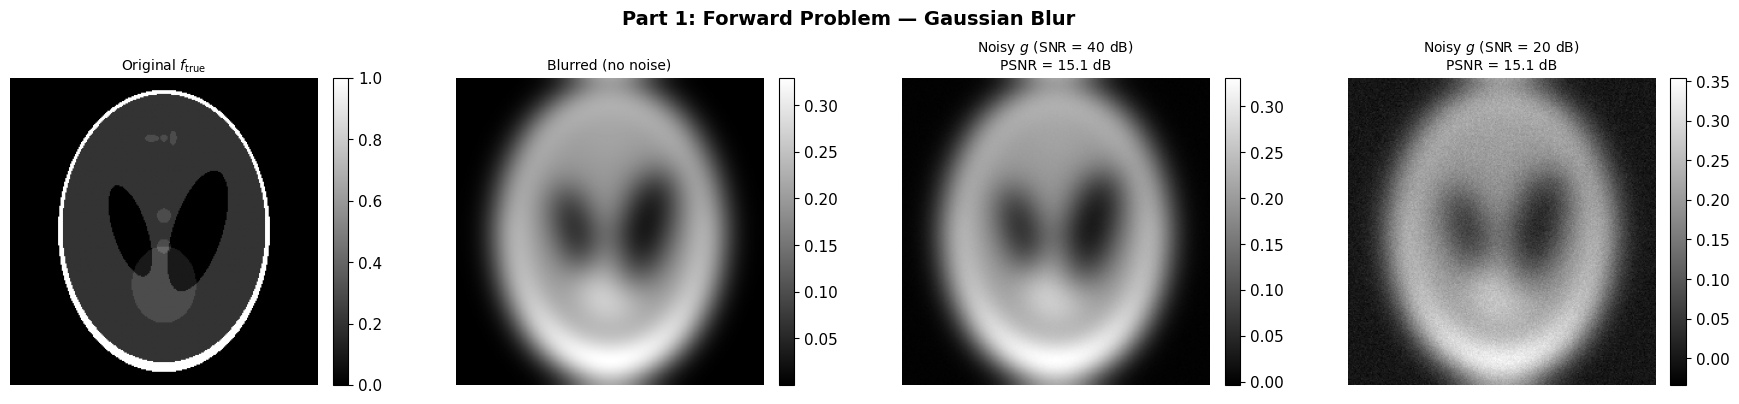

In [9]:
show_images(
    [f_true, g_clean, g_high, g_low],
    ['Original $f_{\\mathrm{true}}$',
     'Blurred (no noise)',
     f'Noisy $g$ (SNR = 40 dB)\nPSNR = {compute_psnr(f_true, g_high):.1f} dB',
     f'Noisy $g$ (SNR = 20 dB)\nPSNR = {compute_psnr(f_true, g_low):.1f} dB'],
    suptitle='Part 1: Forward Problem — Gaussian Blur',
    figsize=(18, 4)
)

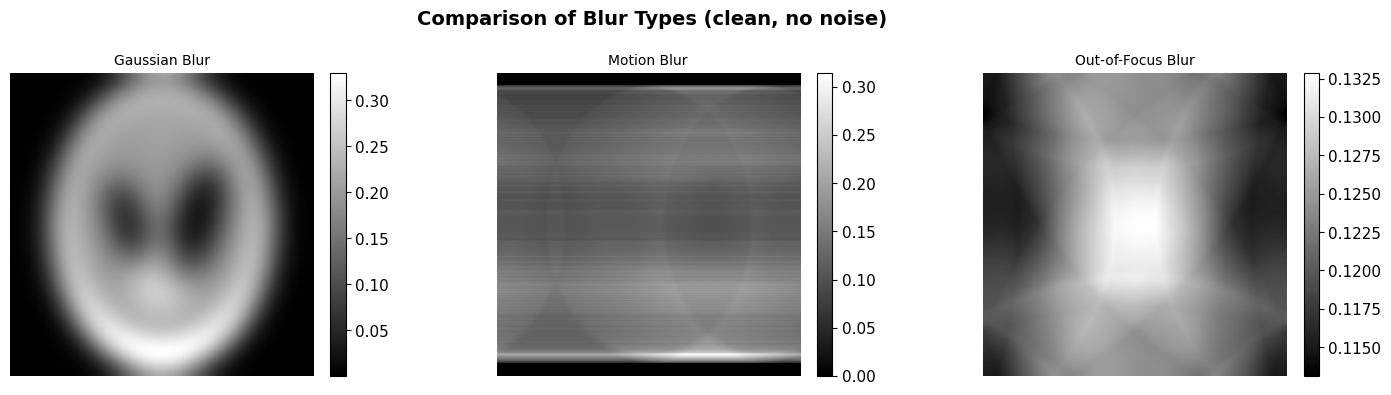

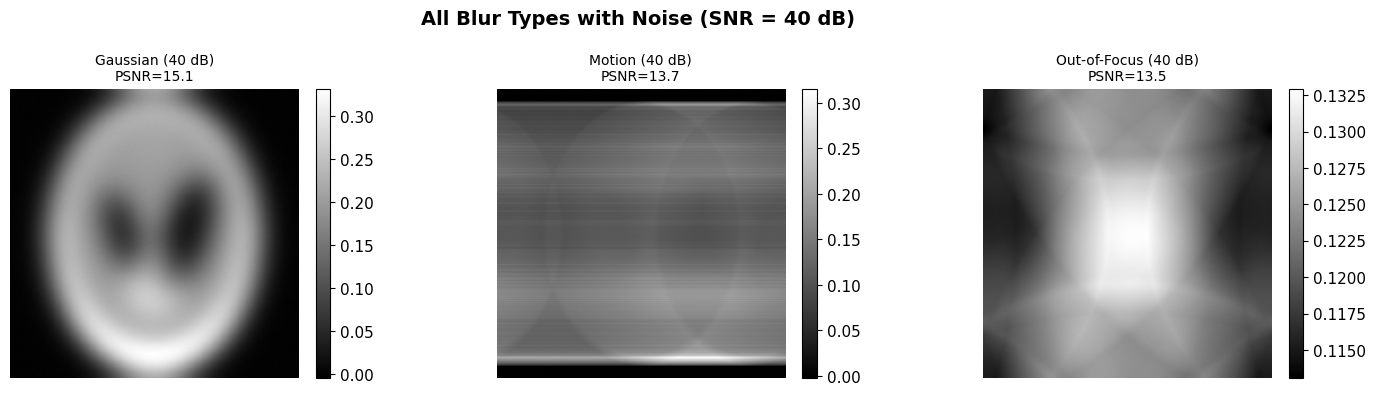

In [10]:
# Let's see what all three blur types look like — clean and noisy versions
show_images(
    [g_clean, g_motion_clean, g_oof_clean],
    ['Gaussian Blur', 'Motion Blur', 'Out-of-Focus Blur'],
    suptitle='Comparison of Blur Types (clean, no noise)',
    figsize=(15, 4)
)

show_images(
    [g_high, g_motion_high, g_oof_high],
    [f'Gaussian (40 dB)\nPSNR={compute_psnr(f_true, g_high):.1f}',
     f'Motion (40 dB)\nPSNR={compute_psnr(f_true, g_motion_high):.1f}',
     f'Out-of-Focus (40 dB)\nPSNR={compute_psnr(f_true, g_oof_high):.1f}'],
    suptitle='All Blur Types with Noise (SNR = 40 dB)',
    figsize=(15, 4)
)

---
## Part 2 — Generalized Tikhonov Regularization

Instead of naively dividing $\hat{g}/\hat{K}$ (which amplifies noise to infinity at high frequencies), we multiply by a filter that smoothly damps those dangerous frequencies:

$$\hat{f}_\mu(\omega) = \frac{\hat{K}^*(\omega)}{|\hat{K}(\omega)|^2 + \mu\,|P(\omega)|^2}\;\hat{g}(\omega)$$

The polynomial $|P(\omega)|^2$ controls *what* we penalize:

| Penalty | $|P(\omega)|^2$ | What it penalizes |
|---------|-----------------|-------------------|
| **$L^2$** | $1$ | Total energy $\|f\|^2$ |
| **$H^1$** | $\omega_1^2 + \omega_2^2$ | Gradient energy $\|\nabla f\|^2$ |
| **$H^2$** | $(\omega_1^2 + \omega_2^2)^2$ | Curvature energy $\|\nabla^2 f\|^2$ |

In 2D, $\omega^2 \to \omega_1^2 + \omega_2^2 = |\omega|^2$ and $\omega^4 \to |\omega|^4$.

In [11]:
# Build the penalty |P(omega)|^2 on the centred grid, then ifftshift
# to match the FFT layout.
#
# L2: penalize all frequencies equally -> P_sq = 1
# H1: penalize the gradient -> |omega|^2
# H2: penalize the Laplacian -> |omega|^4

P_sq_L2_c = np.ones((N, M))
P_sq_H1_c = omega_X**2 + omega_Y**2
P_sq_H2_c = (omega_X**2 + omega_Y**2)**2

P_sq_L2 = ifftshift(P_sq_L2_c)
P_sq_H1 = ifftshift(P_sq_H1_c)
P_sq_H2 = ifftshift(P_sq_H2_c)

penalties = {'L2': P_sq_L2, 'H1': P_sq_H1, 'H2': P_sq_H2}

In [12]:
def tikhonov_reconstruct(g_hat, K_hat, P_sq, mu):
    """Algorithm 3: Generalized Tikhonov reconstruction.
    f_hat_mu = K_hat* / (|K_hat|^2 + mu * |P|^2) * g_hat
    Everything in frequency domain, then ifft2 back to spatial.
    """
    denominator = np.abs(K_hat)**2 + mu * P_sq
    f_hat_mu = np.conj(K_hat) * g_hat / denominator
    return np.real(ifft2(f_hat_mu))

In [13]:
# mu should be smaller when noise is low and larger when noise is high
mu_high_snr = 1e-3   # for 40 dB
mu_low_snr  = 1e-1   # for 20 dB

# Reconstruct with all three penalties at both noise levels
results_high = {}
for name, P_sq in penalties.items():
    results_high[name] = tikhonov_reconstruct(g_hat_high, K_hat_primary, P_sq, mu_high_snr)

results_low = {}
for name, P_sq in penalties.items():
    results_low[name] = tikhonov_reconstruct(g_hat_low, K_hat_primary, P_sq, mu_low_snr)

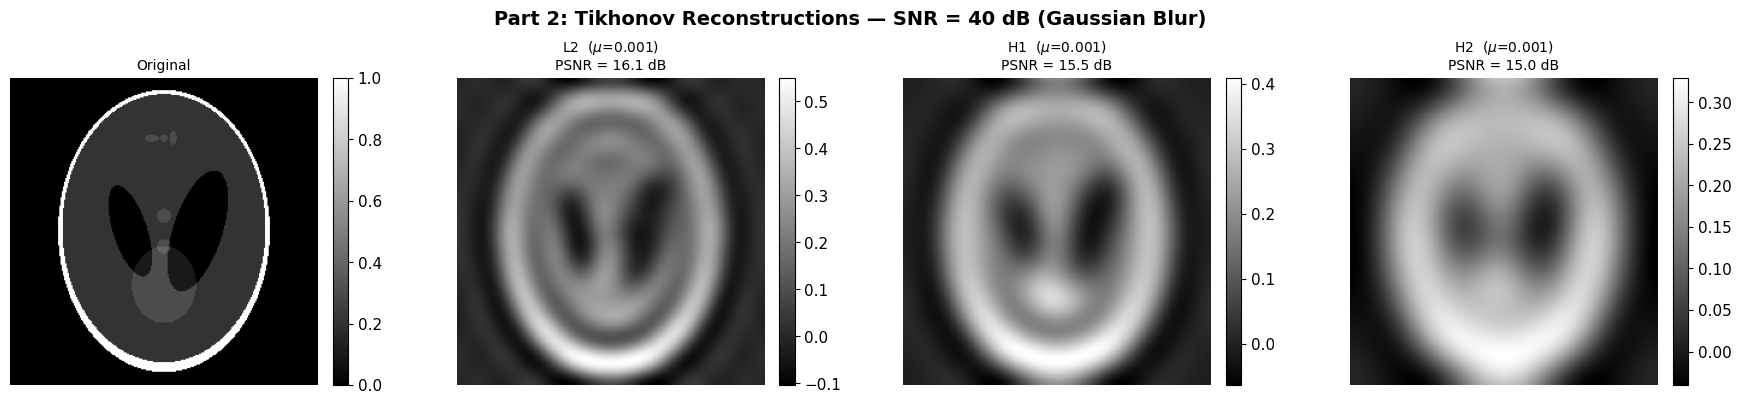

In [14]:
# High-SNR results
imgs  = [f_true] + [results_high[n] for n in ['L2', 'H1', 'H2']]
titles = ['Original'] + [
    f'{n}  ($\\mu$={mu_high_snr})\nPSNR = {compute_psnr(f_true, results_high[n]):.1f} dB'
    for n in ['L2', 'H1', 'H2']
]
show_images(imgs, titles,
            suptitle='Part 2: Tikhonov Reconstructions — SNR = 40 dB (Gaussian Blur)',
            figsize=(18, 4))

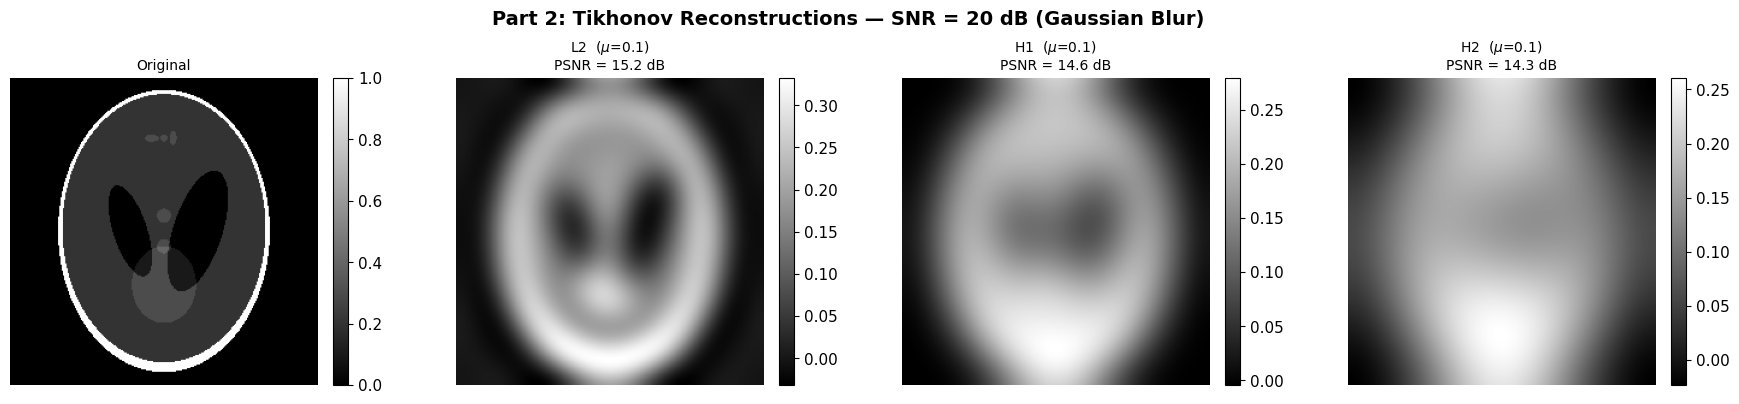

In [15]:
# Low-SNR results
imgs  = [f_true] + [results_low[n] for n in ['L2', 'H1', 'H2']]
titles = ['Original'] + [
    f'{n}  ($\\mu$={mu_low_snr})\nPSNR = {compute_psnr(f_true, results_low[n]):.1f} dB'
    for n in ['L2', 'H1', 'H2']
]
show_images(imgs, titles,
            suptitle='Part 2: Tikhonov Reconstructions — SNR = 20 dB (Gaussian Blur)',
            figsize=(18, 4))

### Tikhonov Reconstruction — Motion Blur and Out-of-Focus

The same formula works regardless of which blur kernel $\hat{K}$ we plug in. Let's reconstruct from motion blur and out-of-focus blur to see how the penalties behave when the transfer function has zeros (out-of-focus) or is complex-valued (motion blur).

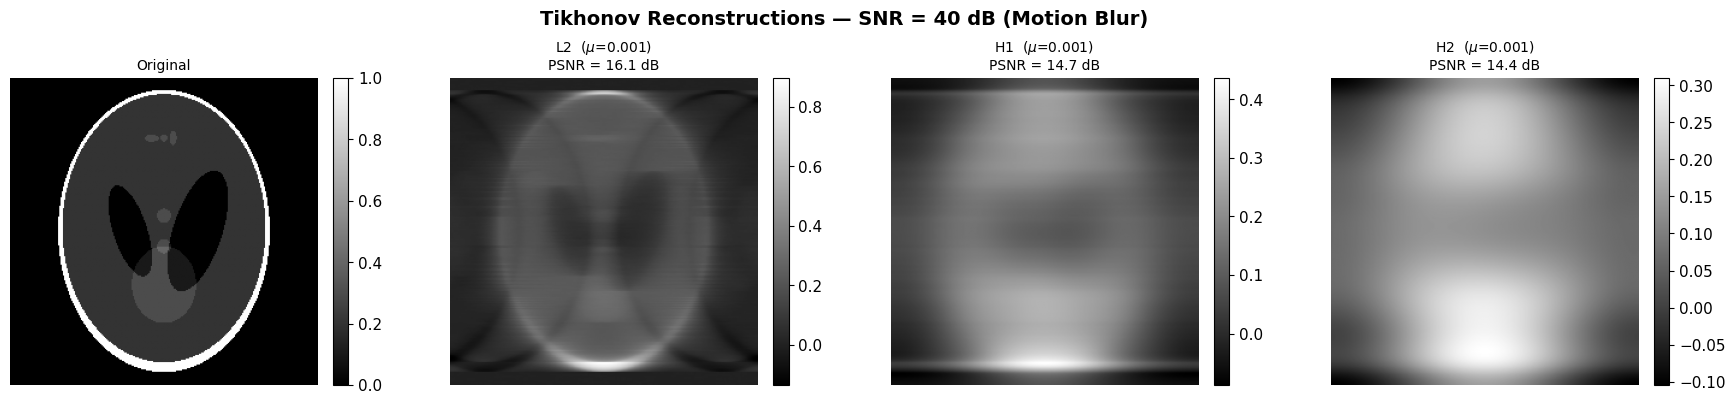

In [35]:
# Tikhonov reconstruction for MOTION BLUR at 40 dB
# Motion kernel is complex (has a phase factor), but np.conj(K_hat) handles it
results_motion_high = {}
for name, P_sq in penalties.items():
    results_motion_high[name] = tikhonov_reconstruct(
        g_hat_motion_high, K_hat_motion, P_sq, mu_high_snr)

imgs  = [f_true] + [results_motion_high[n] for n in ['L2', 'H1', 'H2']]
titles = ['Original'] + [
    f'{n}  ($\\mu$={mu_high_snr})\nPSNR = {compute_psnr(f_true, results_motion_high[n]):.1f} dB'
    for n in ['L2', 'H1', 'H2']
]
show_images(imgs, titles,
            suptitle='Tikhonov Reconstructions — SNR = 40 dB (Motion Blur)',
            figsize=(18, 4))

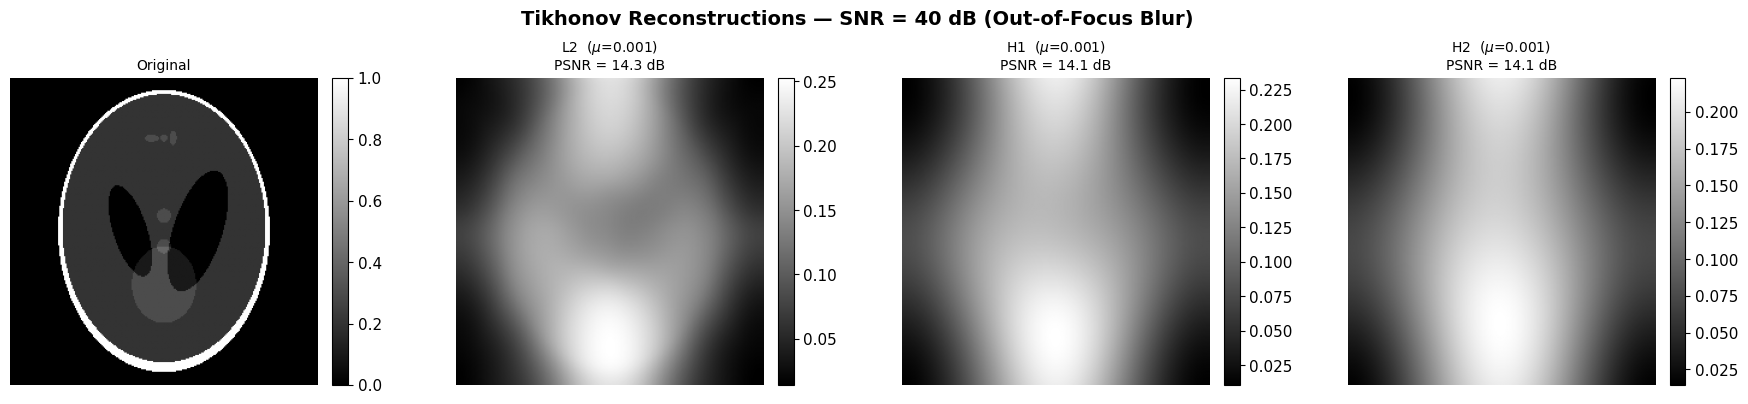

In [32]:
# Tikhonov reconstruction for OUT-OF-FOCUS BLUR at 40 dB
# This kernel has actual zeros (where J1 crosses zero), but Tikhonov
# still works because |K_hat|^2 + mu*|P|^2 never hits zero.

results_oof_high = {}
for name, P_sq in penalties.items():
    results_oof_high[name] = tikhonov_reconstruct(
        g_hat_oof_high, K_hat_oof, P_sq, mu_high_snr)

imgs  = [f_true] + [results_oof_high[n] for n in ['L2', 'H1', 'H2']]
titles = ['Original'] + [
    f'{n}  ($\\mu$={mu_high_snr})\nPSNR = {compute_psnr(f_true, results_oof_high[n]):.1f} dB'
    for n in ['L2', 'H1', 'H2']
]
show_images(imgs, titles,
            suptitle='Tikhonov Reconstructions — SNR = 40 dB (Out-of-Focus Blur)',
            figsize=(18, 4))

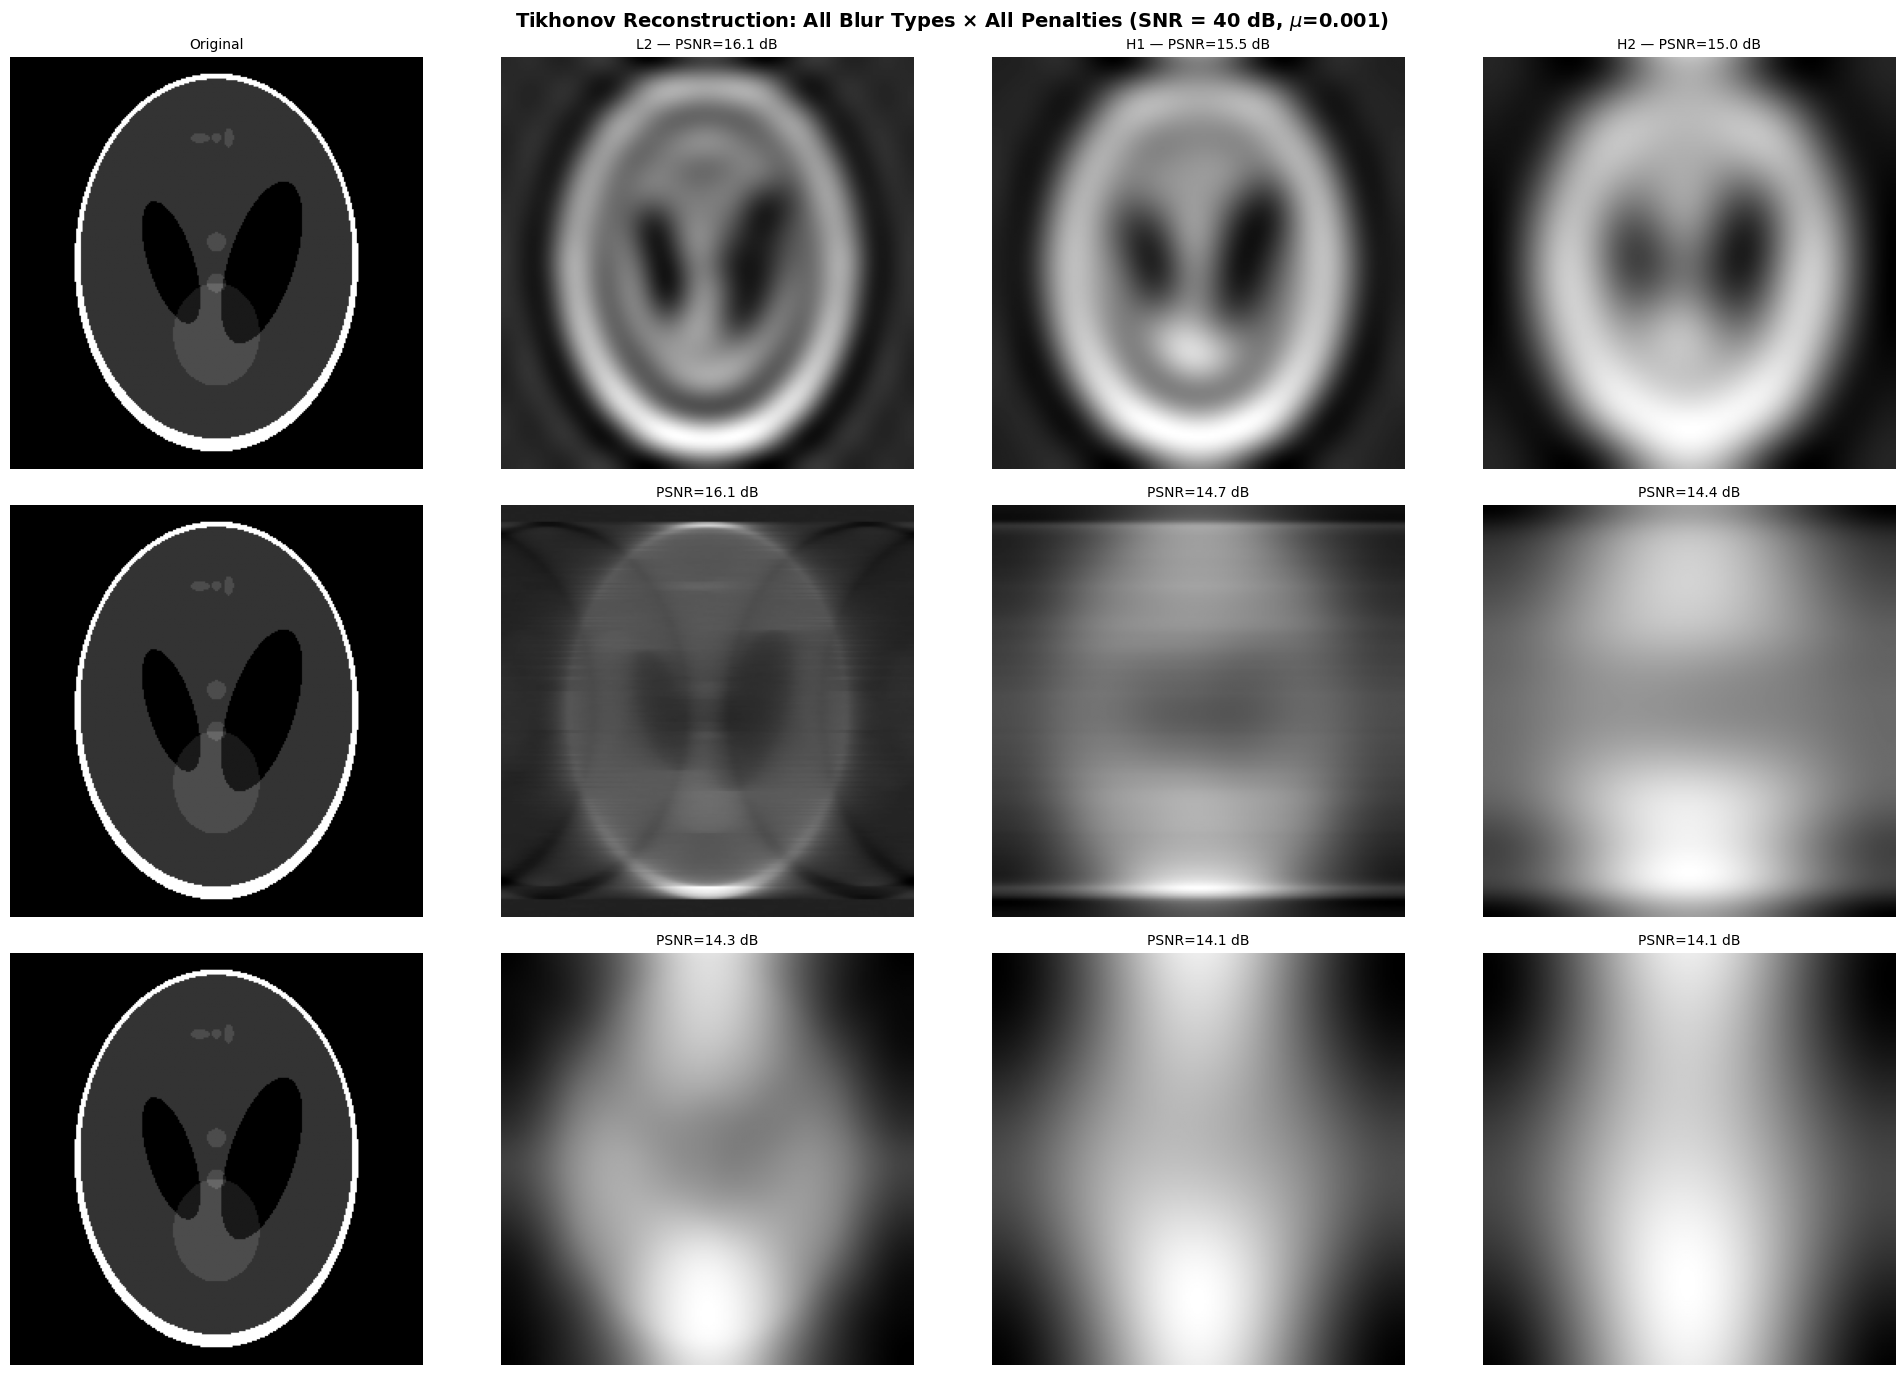

In [34]:
# Side-by-side comparison: all 3 blur types x all 3 penalties (40 dB)
# This is the comprehensive grid — rows = blur types, columns = penalties
fig, axes = plt.subplots(3, 4, figsize=(20, 14))

blur_data = [
    ('Gaussian',     results_high),
    ('Motion',       results_motion_high),
    ('Out-of-Focus', results_oof_high),
]

for row, (blur_name, results) in enumerate(blur_data):
    axes[row, 0].imshow(f_true, cmap='gray')
    axes[row, 0].set_title('Original' if row == 0 else '', fontsize=10)
    axes[row, 0].set_ylabel(blur_name, fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    for col, pen_name in enumerate(['L2', 'H1', 'H2']):
        psnr = compute_psnr(f_true, results[pen_name])
        axes[row, col + 1].imshow(results[pen_name], cmap='gray')
        axes[row, col + 1].set_title(
            f'{pen_name} — PSNR={psnr:.1f} dB' if row == 0 else f'PSNR={psnr:.1f} dB',
            fontsize=10)
        axes[row, col + 1].axis('off')

fig.suptitle('Tikhonov Reconstruction: All Blur Types × All Penalties (SNR = 40 dB, $\\mu$=0.001)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

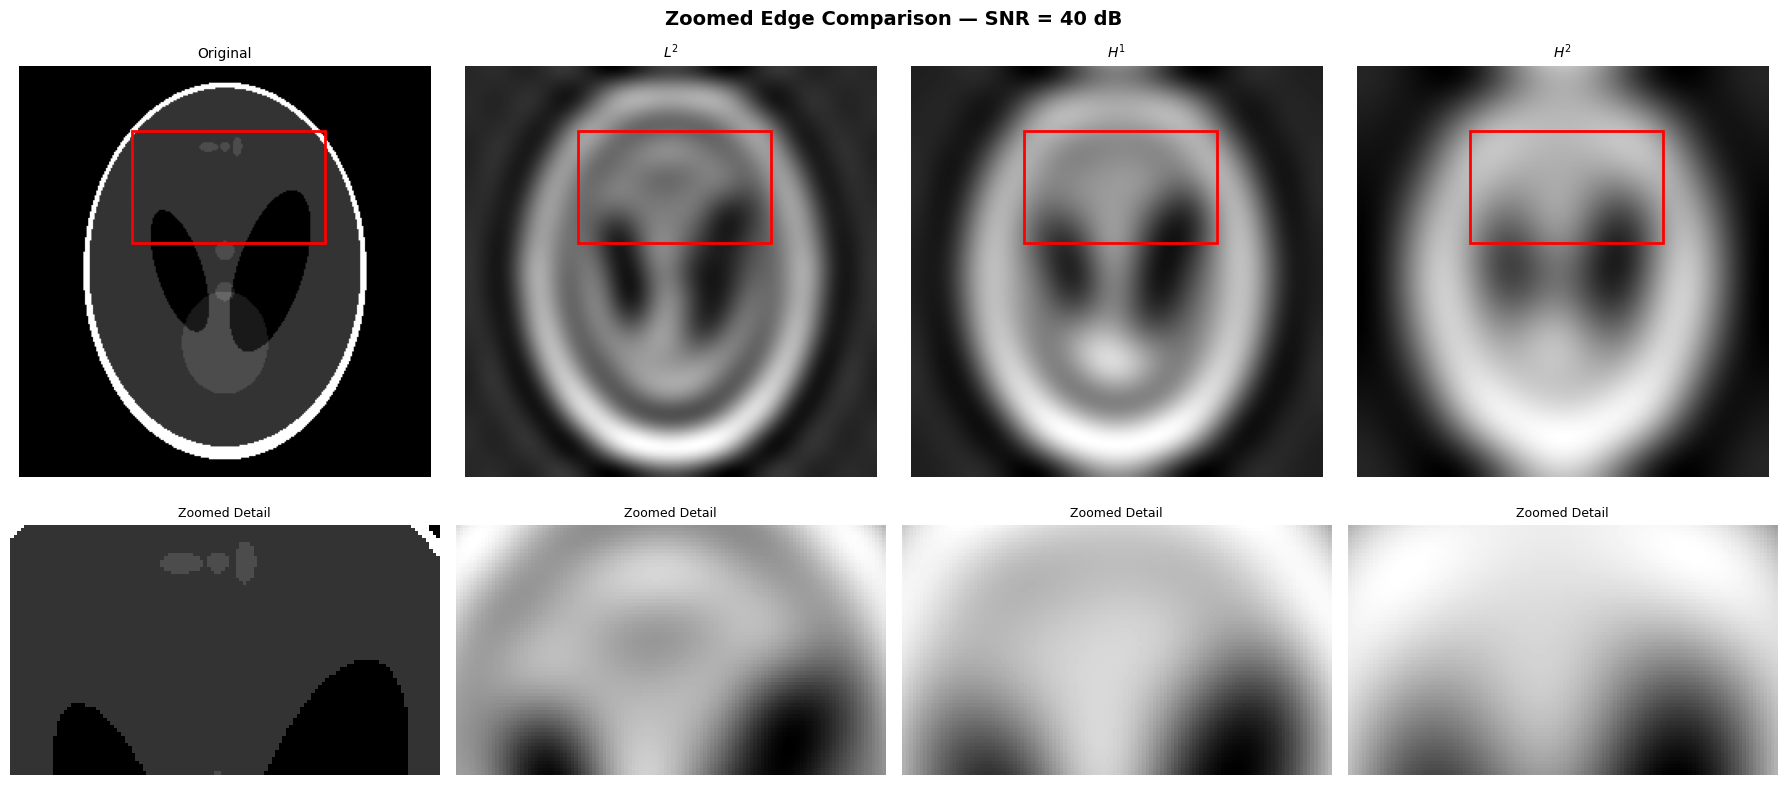

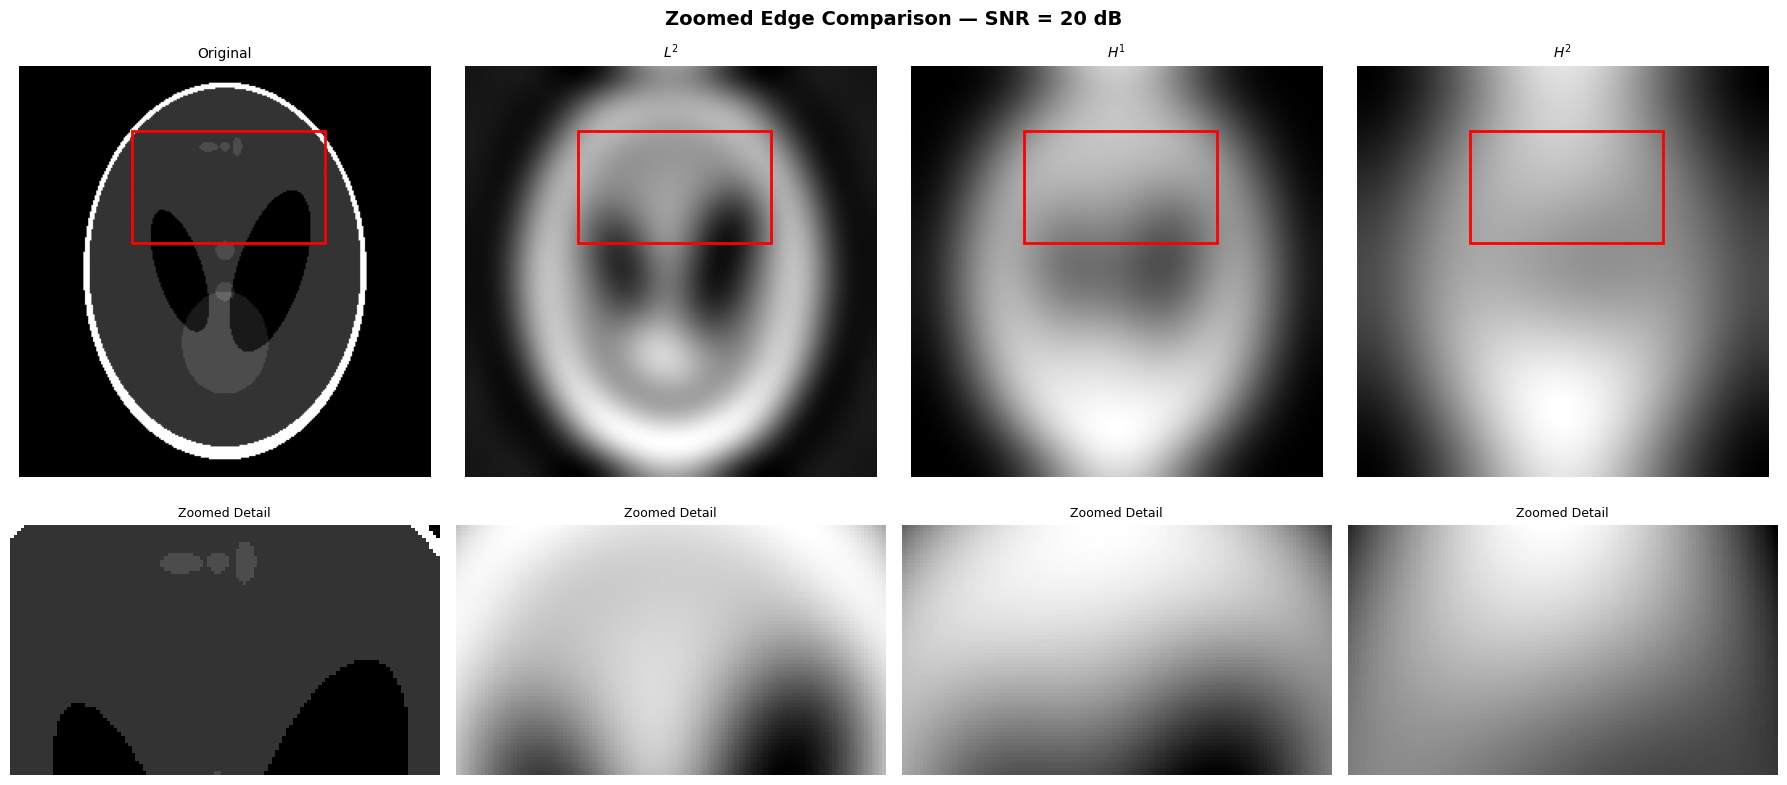

In [19]:
# Zoom into a region with sharp edges to compare L2, H1, H2
zoom_region = (40, 110, 70, 190)

show_zoom(
    [f_true] + [results_high[n] for n in ['L2', 'H1', 'H2']],
    ['Original', '$L^2$', '$H^1$', '$H^2$'],
    zoom_region,
    suptitle='Zoomed Edge Comparison — SNR = 40 dB',
    figsize=(18, 4)
)

show_zoom(
    [f_true] + [results_low[n] for n in ['L2', 'H1', 'H2']],
    ['Original', '$L^2$', '$H^1$', '$H^2$'],
    zoom_region,
    suptitle='Zoomed Edge Comparison — SNR = 20 dB',
    figsize=(18, 4)
)

### Discussion — Edge Preservation

Looking at the zoomed images, the differences are clear:

- **$L^2$ (standard Tikhonov):** Penalizes $\|f\|^2$, which treats all frequencies the same. The result is uniform smoothing — edges get blurred just like everything else. The filter acts like a soft frequency switch.

- **$H^1$ penalty:** Since $|P(0)|^2 = 0$, low frequencies pass through without penalty. Only higher frequencies get damped, and the penalty grows as $|\omega|^2$. This is why $H^1$ preserves edges better — edges live in the low-to-mid frequency range, and those are penalized less.

- **$H^2$ penalty:** The $|\omega|^4$ term crushes high frequencies much more aggressively than $H^1$. Very smooth result (almost too smooth) — good at killing noise but loses fine detail.

---
## Part 3 — Spectral Windowing (Comparison)

Instead of Tikhonov's smooth roll-off, we can use a **hard frequency cutoff** — keep all frequencies below some threshold $\Omega$ and throw away everything above:

$$\hat{f}_\Omega(\omega) = \hat{W}_\Omega(\omega)\,\frac{\hat{g}(\omega)}{\hat{K}(\omega)}, \qquad
\hat{W}_\Omega(\omega) = \begin{cases} 1 & |\omega| < \Omega \\ 0 & |\omega| \ge \Omega \end{cases}$$

The problem is that a sharp cutoff in frequency = convolving with a sinc in space (FT of a rectangle is a sinc). This produces **Gibbs ringing** near sharp edges.

In [20]:
def spectral_window_reconstruct(g_hat, K_hat, Omega_cutoff, omega_mag_fft):
    """Hard cutoff reconstruction.
    Only invert K_hat where |omega| < Omega, set everything else to zero.
    """
    W = (omega_mag_fft < Omega_cutoff).astype(float)
    f_hat_Omega = np.zeros_like(g_hat)
    mask = W > 0
    f_hat_Omega[mask] = W[mask] * g_hat[mask] / K_hat[mask]
    return np.real(ifft2(f_hat_Omega))


# |omega| in FFT layout to match g_hat and K_hat
omega_mag_fft = ifftshift(omega_mag)

# try several cutoff radii
cutoffs = [20, 40, 60, 80]
window_results = {}
for Omega in cutoffs:
    window_results[Omega] = spectral_window_reconstruct(
        g_hat_high, K_hat_primary, Omega, omega_mag_fft
    )

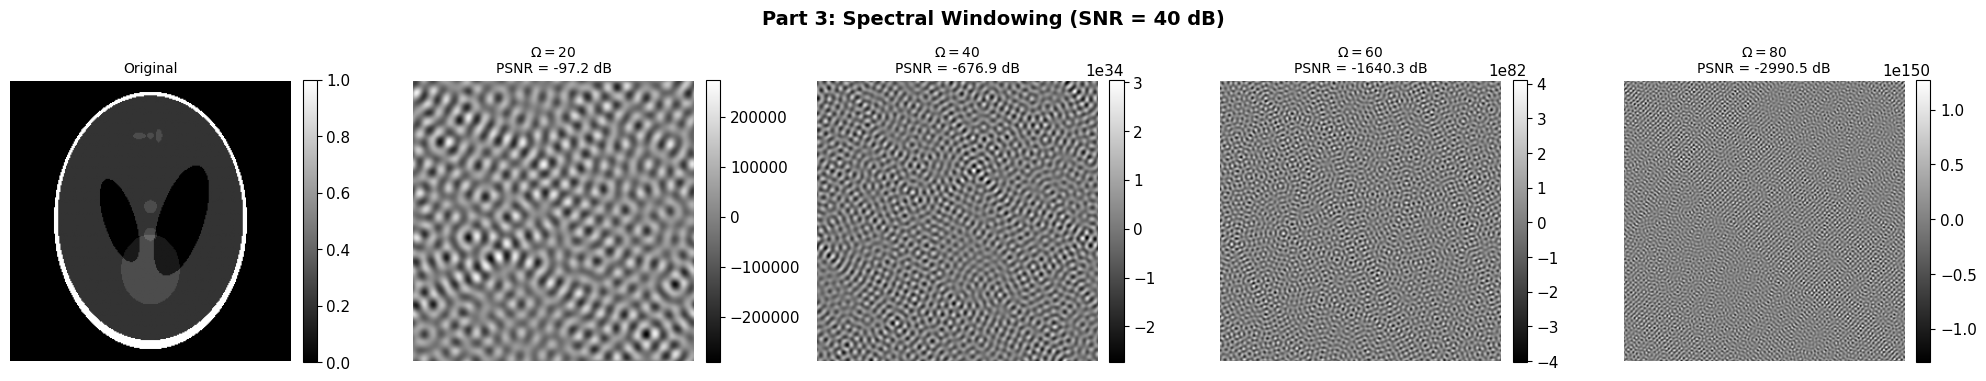

In [21]:
imgs   = [f_true] + [window_results[O] for O in cutoffs]
titles = ['Original'] + [
    f'$\\Omega = {O}$\nPSNR = {compute_psnr(f_true, window_results[O]):.1f} dB'
    for O in cutoffs
]
show_images(imgs, titles,
            suptitle='Part 3: Spectral Windowing (SNR = 40 dB)',
            figsize=(20, 4))

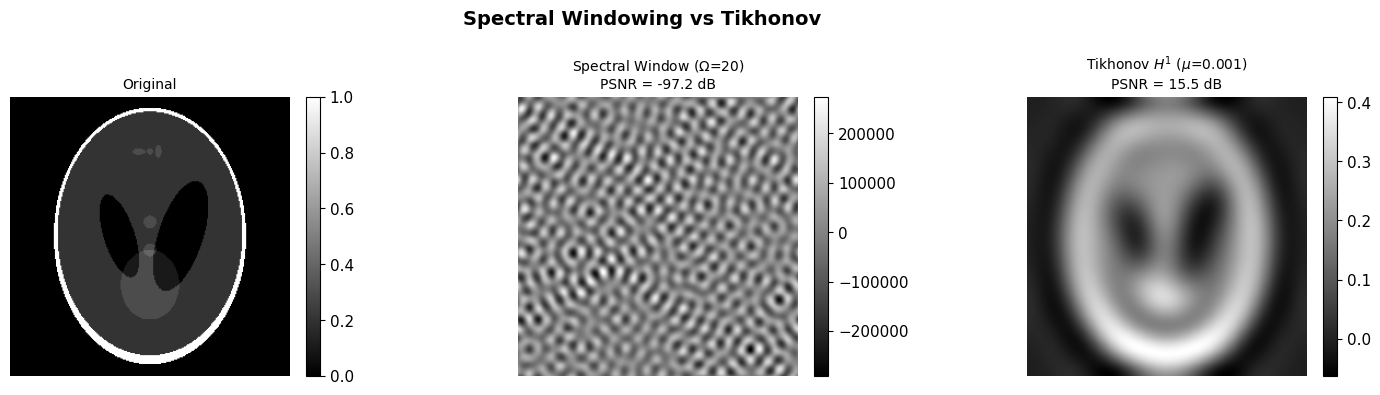

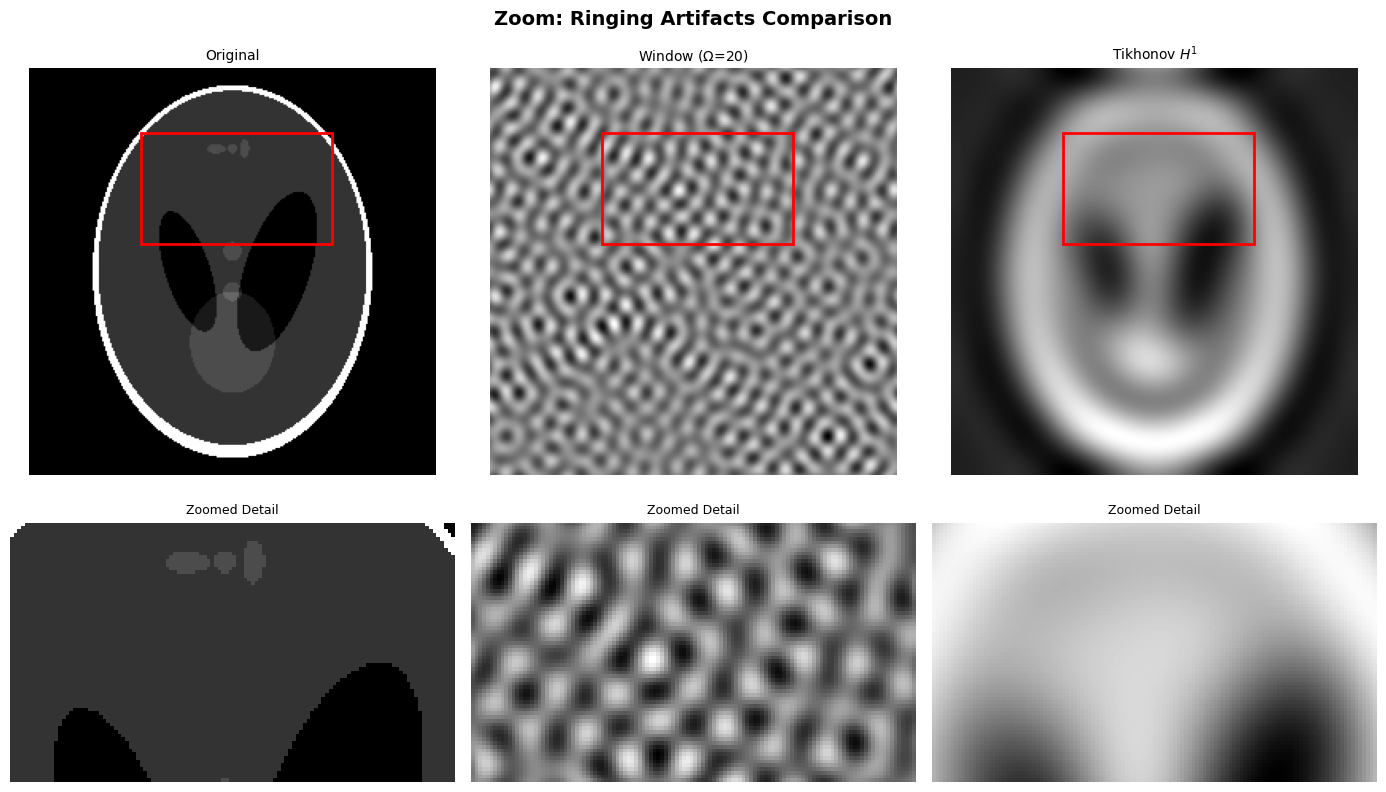

In [22]:
# Compare the best windowed result against Tikhonov H1
best_Omega = max(cutoffs, key=lambda O: compute_psnr(f_true, window_results[O]))
f_window_best = window_results[best_Omega]
f_tikh_best   = results_high['H1']

show_images(
    [f_true, f_window_best, f_tikh_best],
    ['Original',
     f'Spectral Window ($\\Omega$={best_Omega})\nPSNR = {compute_psnr(f_true, f_window_best):.1f} dB',
     f'Tikhonov $H^1$ ($\\mu$={mu_high_snr})\nPSNR = {compute_psnr(f_true, f_tikh_best):.1f} dB'],
    suptitle='Spectral Windowing vs Tikhonov',
    figsize=(15, 4)
)

# Zoom in to see the ringing artifacts from the hard cutoff
show_zoom(
    [f_true, f_window_best, f_tikh_best],
    ['Original', f'Window ($\\Omega$={best_Omega})', 'Tikhonov $H^1$'],
    zoom_region,
    suptitle='Zoom: Ringing Artifacts Comparison',
    figsize=(14, 4)
)

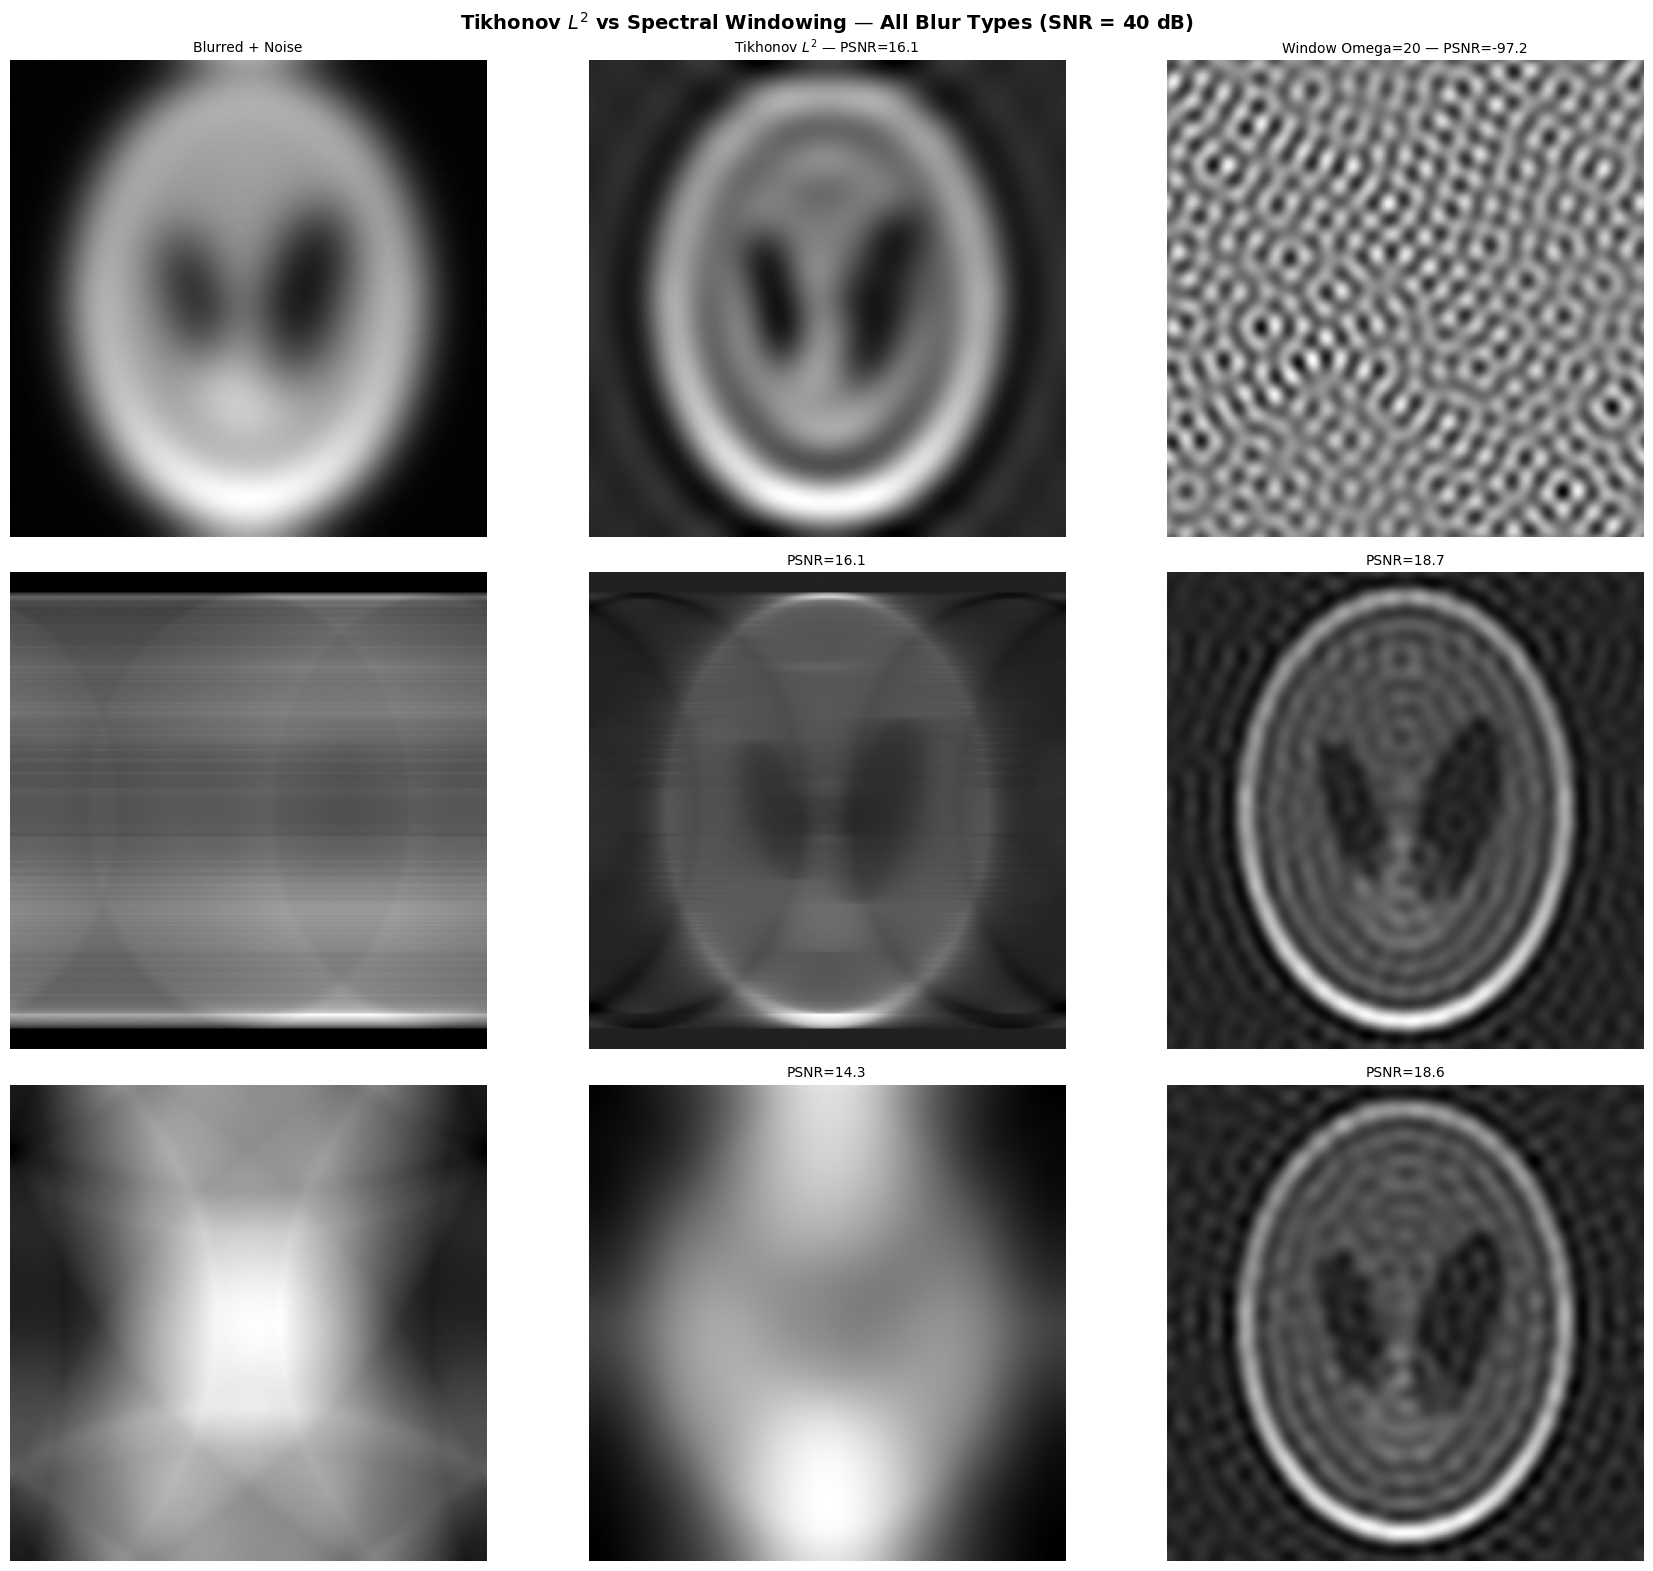

In [30]:
# Spectral windowing for motion blur and out-of-focus blur
# Using the same best Omega found from the Gaussian case
window_motion = spectral_window_reconstruct(
    g_hat_motion_high, K_hat_motion, best_Omega, omega_mag_fft)
window_oof = spectral_window_reconstruct(
    g_hat_oof_high, K_hat_oof, best_Omega, omega_mag_fft)

# Compare Tikhonov L2 vs Spectral Window across all 3 blur types
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

blur_window_data = [
    ('Gaussian',     results_high['L2'],        f_window_best,  g_high),
    ('Motion',       results_motion_high['L2'],  window_motion,  g_motion_high),
    ('Out-of-Focus', results_oof_high['L2'],     window_oof,     g_oof_high),
]

for row, (blur_name, tikh_img, win_img, blurred) in enumerate(blur_window_data):
    # column 0: blurred observation
    axes[row, 0].imshow(blurred, cmap='gray')
    axes[row, 0].set_title('Blurred + Noise' if row == 0 else '', fontsize=10)
    axes[row, 0].set_ylabel(blur_name, fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    # column 1: Tikhonov L2
    psnr_t = compute_psnr(f_true, tikh_img)
    axes[row, 1].imshow(tikh_img, cmap='gray')
    axes[row, 1].set_title(
        f'Tikhonov $L^2$ — PSNR={psnr_t:.1f}' if row == 0 else f'PSNR={psnr_t:.1f}',
        fontsize=10)
    axes[row, 1].axis('off')
    # column 2: Spectral window
    psnr_w = compute_psnr(f_true, win_img)
    axes[row, 2].imshow(win_img, cmap='gray')
    axes[row, 2].set_title(
        f'Window Omega={best_Omega} — PSNR={psnr_w:.1f}' if row == 0 else f'PSNR={psnr_w:.1f}',
        fontsize=10)
    axes[row, 2].axis('off')

fig.suptitle('Tikhonov $L^2$ vs Spectral Windowing — All Blur Types (SNR = 40 dB)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Discussion — Spectral Windowing vs Tikhonov

The comparison shows the difference clearly:

- The **hard cutoff** creates visible oscillations (Gibbs ringing) near every sharp edge. A rectangular window in frequency = convolving with a sinc in space, and the sinc's side lobes produce those ripples.

- **Tikhonov** provides a smooth transition: the filter $|\hat{K}|^2 / (|\hat{K}|^2 + \mu|P|^2)$ gradually rolls off instead of dropping to zero abruptly. No ringing, but the transition zone is wider.

- There's also a practical trade-off with $\Omega$: too small and we lose resolution (over-smoothed), too large and we amplify noise. Tikhonov handles this balance automatically through $\mu$.

---
## Part 4 — The Bias-Variance Trade-off

This is the key to understanding *why* there's an optimal $\mu$. The reconstruction error splits into two terms:

$$f_\mu - f^{(0)} = \underbrace{(R_\mu A - I)\,f^{(0)}}_{\text{Bias}} + \underbrace{R_\mu\,w}_{\text{Noise}}$$

where $R_\mu(\omega) = \hat{K}^*(\omega) / (|\hat{K}(\omega)|^2 + \mu|P(\omega)|^2)$. Taking squared norms:

$$\text{Total Error}^2 = \underbrace{\|(R_\mu A - I)f^{(0)}\|^2}_{\text{Bias}^2} + \underbrace{\|R_\mu w\|^2}_{\text{Variance}}$$

- $\mu \to 0$: bias vanishes but variance explodes (unstable inverse).
- $\mu \to \infty$: variance vanishes but bias maxes out (we lose all info).

I compute both terms in the frequency domain using Parseval's identity:

$$\text{Bias}^2 = \frac{1}{NM}\sum_\omega |R_\mu(\omega)\hat{K}(\omega) - 1|^2\;|\hat{f}_{\text{true}}(\omega)|^2$$

$$\mathbb{E}[\text{Variance}] = \sigma^2 \sum_\omega |R_\mu(\omega)|^2$$

In [38]:
def compute_bias_variance(K_hat, P_sq, f_true, sigma_noise, mu_values):
    """Compute bias^2, variance, and total error for each mu.
    Everything in Fourier domain via Parseval: ||h||^2 = (1/NM) * sum|h_hat|^2.
    """
    N_pix = K_hat.shape[0] * K_hat.shape[1]
    f_hat_true = fft2(f_true)
    f_hat_sq = np.abs(f_hat_true)**2
    K_hat_sq = np.abs(K_hat)**2

    bias_vals = np.zeros(len(mu_values))
    var_vals  = np.zeros(len(mu_values))

    for i, mu in enumerate(mu_values):
        denom = K_hat_sq + mu * P_sq
        R_mu  = np.conj(K_hat) / denom

        # bias: how far is R_mu * K from the identity
        R_K_minus_1 = R_mu * K_hat - 1.0
        bias_vals[i] = (1.0 / N_pix) * np.sum(np.abs(R_K_minus_1)**2 * f_hat_sq)

        # variance: how much noise gets through the filter
        var_vals[i] = sigma_noise**2 * np.sum(np.abs(R_mu)**2)

    total_vals = bias_vals + var_vals
    return bias_vals, var_vals, total_vals


# sweep mu over several orders of magnitude
# Adviced -6 was too small, therefore use the -15
mu_range = np.logspace(-15, 0, 100)

bias_h1, var_h1, total_h1 = compute_bias_variance(
    K_hat_primary, P_sq_H1, f_true, sigma_high, mu_range
)

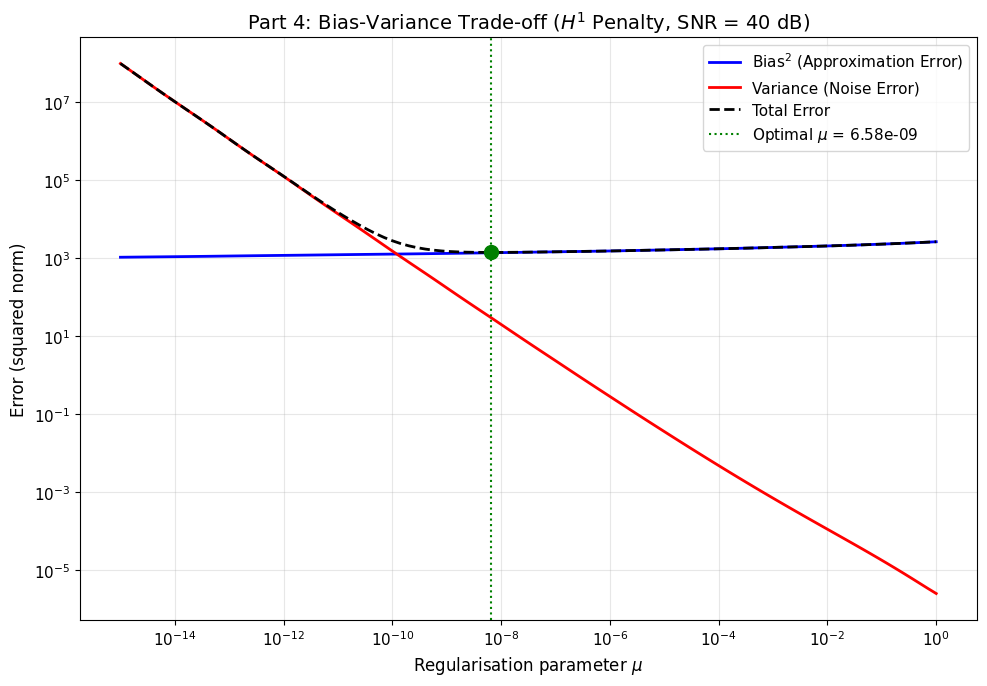

Optimal mu: 6.5793e-09
  Bias^2   = 1.3565e+03
  Variance = 2.9162e+01
  Total    = 1.3857e+03


In [39]:
# Bias-variance plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(mu_range, bias_h1,  'b-',  lw=2, label='Bias$^2$ (Approximation Error)')
ax.loglog(mu_range, var_h1,   'r-',  lw=2, label='Variance (Noise Error)')
ax.loglog(mu_range, total_h1, 'k--', lw=2, label='Total Error')

idx_opt = np.argmin(total_h1)
mu_opt  = mu_range[idx_opt]
ax.axvline(mu_opt, color='green', ls=':', lw=1.5,
           label=f'Optimal $\\mu$ = {mu_opt:.2e}')
ax.plot(mu_opt, total_h1[idx_opt], 'go', ms=10, zorder=5)

ax.set_xlabel('Regularisation parameter $\\mu$', fontsize=12)
ax.set_ylabel('Error (squared norm)', fontsize=12)
ax.set_title('Part 4: Bias-Variance Trade-off ($H^1$ Penalty, SNR = 40 dB)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Optimal mu: {mu_opt:.4e}')
print(f'  Bias^2   = {bias_h1[idx_opt]:.4e}')
print(f'  Variance = {var_h1[idx_opt]:.4e}')
print(f'  Total    = {total_h1[idx_opt]:.4e}')

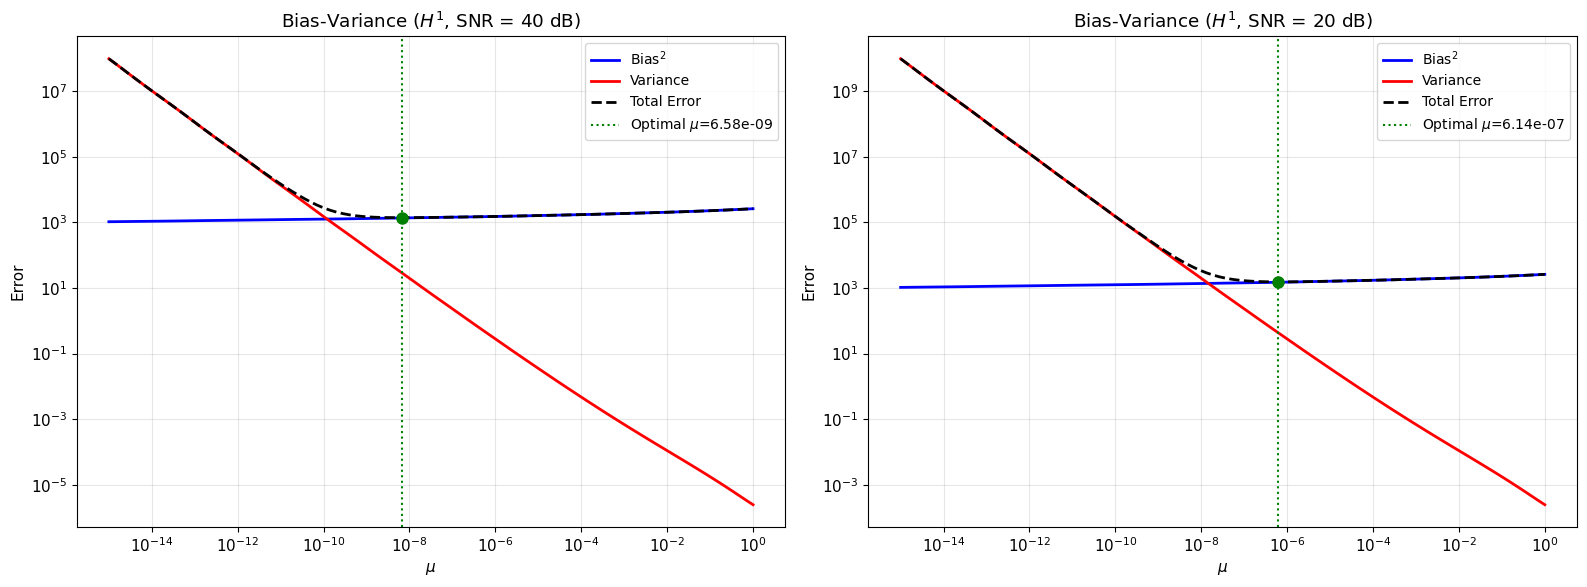

In [40]:
# Compare high SNR vs low SNR side by side
# Bias should be identical (doesn't depend on noise), only variance shifts up
bias_h1_low, var_h1_low, total_h1_low = compute_bias_variance(
    K_hat_primary, P_sq_H1, f_true, sigma_low, mu_range
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, bias, var, total, snr_label in [
    (axes[0], bias_h1,     var_h1,     total_h1,     'SNR = 40 dB'),
    (axes[1], bias_h1_low, var_h1_low, total_h1_low, 'SNR = 20 dB'),
]:
    ax.loglog(mu_range, bias,  'b-',  lw=2, label='Bias$^2$')
    ax.loglog(mu_range, var,   'r-',  lw=2, label='Variance')
    ax.loglog(mu_range, total, 'k--', lw=2, label='Total Error')
    idx = np.argmin(total)
    ax.axvline(mu_range[idx], color='green', ls=':', lw=1.5,
               label=f'Optimal $\\mu$={mu_range[idx]:.2e}')
    ax.plot(mu_range[idx], total[idx], 'go', ms=8)
    ax.set_xlabel('$\\mu$')
    ax.set_ylabel('Error')
    ax.set_title(f'Bias-Variance ($H^1$, {snr_label})')
    ax.legend(fontsize=10)
    ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

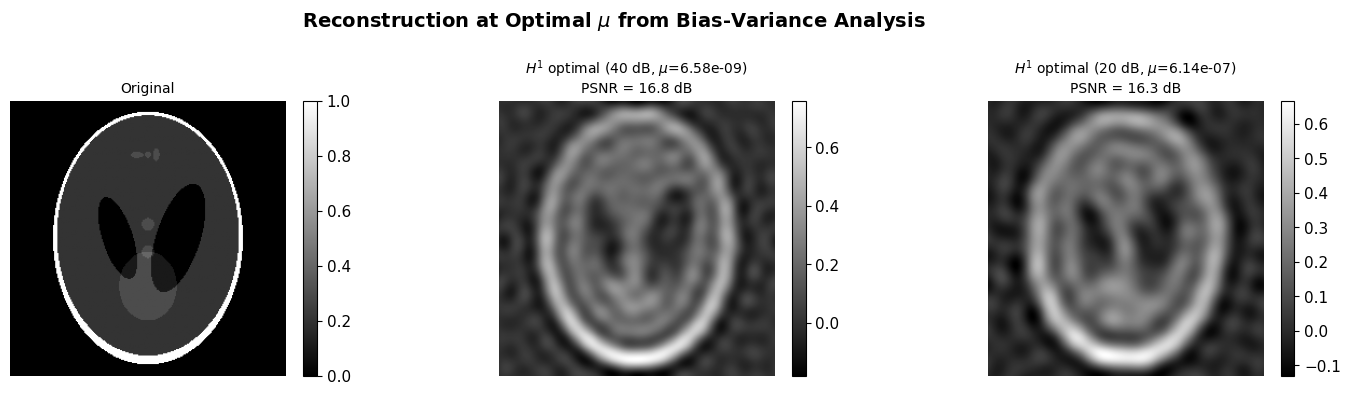

In [41]:
# Use optimal mu from bias-variance to get the best H1 reconstruction
mu_opt_high = mu_range[np.argmin(total_h1)]
mu_opt_low  = mu_range[np.argmin(total_h1_low)]

f_opt_high = tikhonov_reconstruct(g_hat_high, K_hat_primary, P_sq_H1, mu_opt_high)
f_opt_low  = tikhonov_reconstruct(g_hat_low,  K_hat_primary, P_sq_H1, mu_opt_low)

show_images(
    [f_true, f_opt_high, f_opt_low],
    ['Original',
     f'$H^1$ optimal (40 dB, $\\mu$={mu_opt_high:.2e})\n'
     f'PSNR = {compute_psnr(f_true, f_opt_high):.1f} dB',
     f'$H^1$ optimal (20 dB, $\\mu$={mu_opt_low:.2e})\n'
     f'PSNR = {compute_psnr(f_true, f_opt_low):.1f} dB'],
    suptitle='Reconstruction at Optimal $\\mu$ from Bias-Variance Analysis',
    figsize=(15, 4)
)

### Discussion — Bias-Variance Trade-off

The plots show the expected behaviour:

- **Bias** grows with $\mu$: the more we regularize, the further $R_\mu A$ is from the identity, and we lose more detail.
- **Variance** decreases with $\mu$: stronger regularization damps the filter, so less noise leaks through.
- The **total error** has a U-shape on the log-log scale, and its minimum is where bias and variance curves cross — the sweet spot.
- Comparing 40 dB vs 20 dB: the bias curve is **the same** (depends on $f_{\text{true}}$ and $K$, not on noise), but the variance curve shifts up. This pushes the optimal $\mu$ to a larger value — more noise means we need more regularization.

L2: optimal mu = 8.70e-07, min total error = 1.3857e+03
H1: optimal mu = 6.58e-09, min total error = 1.3857e+03
H2: optimal mu = 4.98e-11, min total error = 1.3859e+03


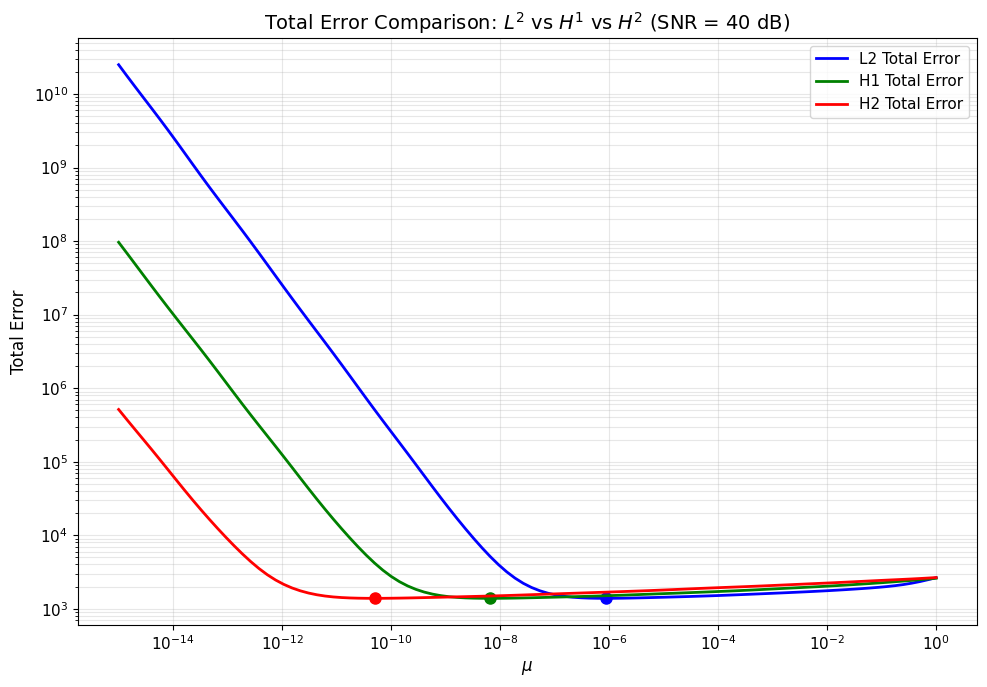

In [42]:
# Compare total error curves for L2, H1, and H2
fig, ax = plt.subplots(figsize=(10, 7))
colors = {'L2': 'blue', 'H1': 'green', 'H2': 'red'}

for name, P_sq in penalties.items():
    b, v, t = compute_bias_variance(K_hat_primary, P_sq, f_true, sigma_high, mu_range)
    ax.loglog(mu_range, t, color=colors[name], lw=2, label=f'{name} Total Error')
    idx = np.argmin(t)
    ax.plot(mu_range[idx], t[idx], 'o', color=colors[name], ms=8)
    print(f'{name}: optimal mu = {mu_range[idx]:.2e}, min total error = {t[idx]:.4e}')

ax.set_xlabel('$\\mu$', fontsize=12)
ax.set_ylabel('Total Error', fontsize=12)
ax.set_title('Total Error Comparison: $L^2$ vs $H^1$ vs $H^2$ (SNR = 40 dB)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Conclusions

**$L^2$ vs $H^1$ vs $H^2$:**

- **$L^2$** penalizes total energy uniformly — it’s a soft switch that treats all frequencies with the same weight. Works, but edges get smoothed.
- **$H^1$** penalizes the gradient, so the penalty scales as $|\omega|^2$. Low frequencies (where edges live) get penalized less, so edges are better preserved. The DC component isn’t penalized at all, which makes sense — regularization shouldn’t change the mean brightness.
- **$H^2$** penalizes curvature with $|\omega|^4$. Crushes high frequencies aggressively. Good for heavy noise, but loses too much detail.

**Spectral windowing vs Tikhonov:**
- Hard cutoffs cause Gibbs ringing because the rectangular window’s FT is a sinc. Tikhonov avoids this through its smooth roll-off.

**Bias-variance trade-off:**
- There is always a sweet-spot $\mu^*$ that balances noise amplification against detail loss.
- More noise → higher optimal $\mu$.
- The bias term doesn’t depend on noise level — only the variance shifts.

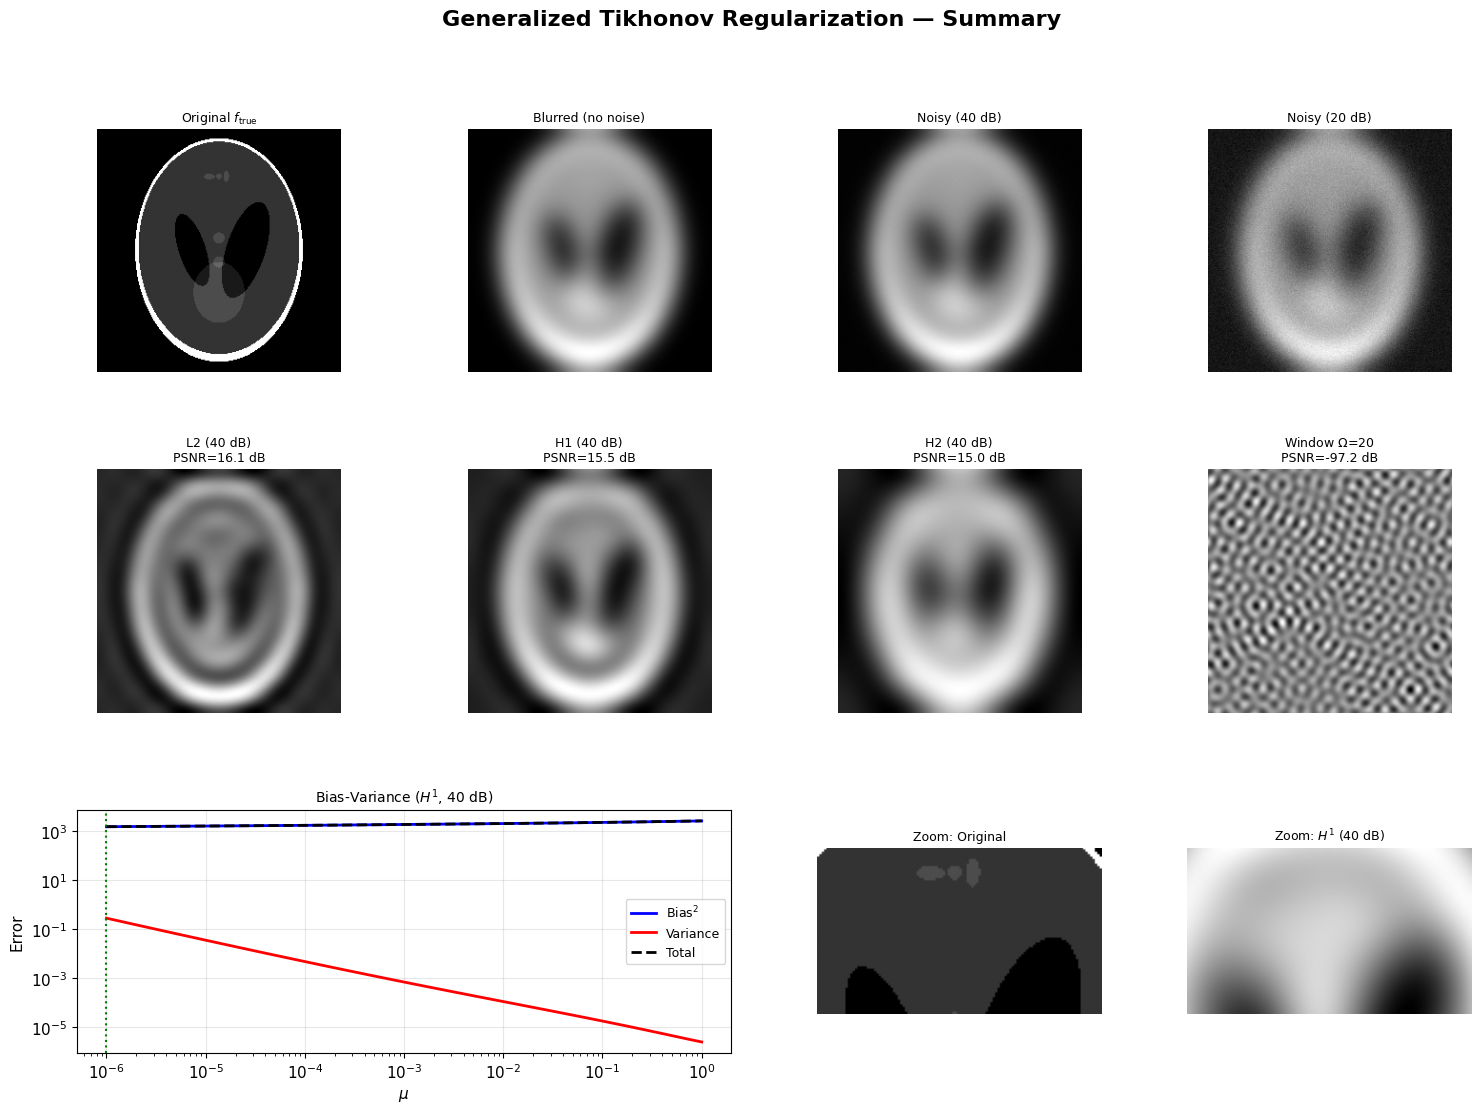

In [29]:
# Summary figure pulling together the key results
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# Row 1: the forward problem
for idx, (img, title) in enumerate([
    (f_true, 'Original $f_{\\mathrm{true}}$'),
    (g_clean, 'Blurred (no noise)'),
    (g_high, 'Noisy (40 dB)'),
    (g_low,  'Noisy (20 dB)'),
]):
    ax = fig.add_subplot(gs[0, idx])
    ax.imshow(img, cmap='gray'); ax.set_title(title, fontsize=9); ax.axis('off')

# Row 2: L2 / H1 / H2 reconstructions + spectral window
for idx, name in enumerate(['L2', 'H1', 'H2']):
    ax = fig.add_subplot(gs[1, idx])
    ax.imshow(results_high[name], cmap='gray')
    psnr = compute_psnr(f_true, results_high[name])
    ax.set_title(f'{name} (40 dB)\nPSNR={psnr:.1f} dB', fontsize=9)
    ax.axis('off')
ax = fig.add_subplot(gs[1, 3])
ax.imshow(f_window_best, cmap='gray')
psnr_w = compute_psnr(f_true, f_window_best)
ax.set_title(f'Window $\\Omega$={best_Omega}\nPSNR={psnr_w:.1f} dB', fontsize=9)
ax.axis('off')

# Row 3 left: bias-variance plot
ax_bv = fig.add_subplot(gs[2, :2])
ax_bv.loglog(mu_range, bias_h1,  'b-',  lw=2, label='Bias$^2$')
ax_bv.loglog(mu_range, var_h1,   'r-',  lw=2, label='Variance')
ax_bv.loglog(mu_range, total_h1, 'k--', lw=2, label='Total')
ax_bv.axvline(mu_opt, color='green', ls=':', lw=1.5)
ax_bv.set_xlabel('$\\mu$'); ax_bv.set_ylabel('Error')
ax_bv.set_title('Bias-Variance ($H^1$, 40 dB)', fontsize=10)
ax_bv.legend(fontsize=9); ax_bv.grid(True, alpha=0.3)

# Row 3 right: zoomed edge comparison
r0, r1, c0, c1 = zoom_region
for idx, (img, name) in enumerate([
    (f_true, 'Original'),
    (results_high['H1'], '$H^1$ (40 dB)'),
]):
    ax = fig.add_subplot(gs[2, 2 + idx])
    ax.imshow(img[r0:r1, c0:c1], cmap='gray')
    ax.set_title(f'Zoom: {name}', fontsize=9); ax.axis('off')

fig.suptitle('Generalized Tikhonov Regularization — Summary',
             fontsize=16, fontweight='bold')
plt.show()